In this notebook create a baseline LightGBM model and performs related feature engineering.

In [1]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

/Users/johndimarco/anaconda3/envs/lending_club/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_df = pd.read_pickle('clean_data/api_train_df.pkl').iloc[:,2:] # first two columns are id info
val_df = pd.read_pickle('clean_data/api_val_df.pkl').iloc[:,2:]
test_df = pd.read_pickle('clean_data/api_val_df.pkl').iloc[:,2:]

Create list of features by removing loan performace info

In [3]:
to_drop = ['issue_d','desc','loan_status', 'total_pymnt','total_rec_int',
           'total_rec_late_fee','total_rec_prncp', 'recoveries', 
           'collection_recovery_fee', 'last_pymnt_d', 
           'loan_length', 'returns']
x_cols = [x for x in list(train_df.columns) if x not in to_drop]

Check which cols are strings

In [4]:
for col in x_cols:
    if train_df[col].dtype == object:
        print(col)

grade
sub_grade
emp_length
home_ownership
verification_status
purpose
zip_code
addr_state
initial_list_status
emp_title
application_type
verification_status_joint
sec_app_earliest_cr_line


To encode the categorical/str columns to numbers:
1. Create a dictionary with encoding info for each column
2. For each column, with the training data create a dict mapping each category to an int
3. Apply the categorical mapping from str to ints on the train and val data

Sklearn label encoder was not used because it has issues if there are values in the val set we are mapping that were not seen in the train encodings. We do not want to fit a label encoder on both train and val data because we are simulating training on historical data to validate against unseen data.

In [5]:
cat_encs = {}

for col in x_cols:
    if train_df[col].dtype == object:
        cat_encs[col] = dict(zip(train_df[col].unique(), range(len(train_df[col].unique()))))
        
for col in cat_encs.keys():
    val_df[col] = val_df[col].map(cat_encs[col], na_action='UNK')
    train_df[col] = train_df[col].map(cat_encs[col], na_action='UNK')
    test_df[col] = test_df[col].map(cat_encs[col], na_action='UNK')

cat_encs is a dictionary of features. each feature is a dictionary with its categorical mapping

In [6]:
cat_encs['purpose']

{'debt_consolidation': 0,
 'other': 1,
 'home_improvement': 2,
 'credit_card': 3,
 'small_business': 4,
 'house': 5,
 'moving': 6,
 'medical': 7,
 'car': 8,
 'major_purchase': 9,
 'vacation': 10,
 'renewable_energy': 11,
 'wedding': 12,
 'educational': 13}

In [7]:
# save the lightgbm formatted data
train_df.to_pickle('clean_data/train_lgbm.pkl')
val_df.to_pickle('clean_data/val_lgbm.pkl')
test_df.to_pickle('clean_data/test_lgbm.pkl')

In [8]:
# split the data from full dfs, to x,y
x_train = train_df[x_cols]
y_train = train_df['loan_status']

x_val = val_df[x_cols]
y_val = val_df['loan_status']

# Label encode target column
y_train = y_train.map({'Fully Paid': 0, 'Charged Off': 1})
y_val = y_val.map({'Fully Paid': 0, 'Charged Off': 1})

Predict loan default

In [9]:
# lgbm with default params
params = {'num_leaves': 32,
          'metric': 'auc',}

# prepare data
train_data = lgb.Dataset(x_train,label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

# train
lgb_model = lgb.train(params,
                      train_data,
                      num_boost_round=1000,
                      valid_sets = [train_data, val_data],
                      verbose_eval=100,
                      early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.732372	valid_1's auc: 0.688922
[200]	training's auc: 0.767839	valid_1's auc: 0.685815
Early stopping, best iteration is:
[118]	training's auc: 0.740094	valid_1's auc: 0.689069


In [10]:
# view most important features
lgb_fi = list(zip(lgb_model.feature_name(),lgb_model.feature_importance(importance_type='gain')))
lgb_fi.sort(key = lambda tup: tup[1], reverse=True)
lgb_fi[:10]

[('int_rate', 2477.808713078499),
 ('annual_inc', 998.7596771717072),
 ('grade', 721.8495355844498),
 ('acc_open_past_24mths', 401.91810071468353),
 ('emp_title', 355.08557373285294),
 ('dti', 345.4366352558136),
 ('installment', 306.18234461545944),
 ('mths_since_recent_bc', 279.92888551950455),
 ('loan_amnt', 272.6489664912224),
 ('total_bc_limit', 256.12167739868164)]

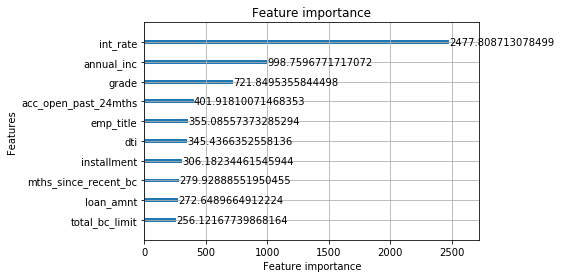

In [11]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=10);

Next view hypothetical returns for different default thresholds. We are most interested in optimizing investment returns

In [12]:
preds = lgb_model.predict(x_val)

In [13]:
val_df['prediction'] = preds

Predicting returns at different default thresholds:
Investing in lendingclub allows you to invest any amount you want into a loan ($25 minimum). Since we invest the same amount into every loan, we can calculate returns by averaging the return on all loans invested.

In [14]:
# creates a list of our hypothetical investment returns for different loan prediction thresholds
thresholds = [x/100 for x in range(0,100)]
returns = []
for thresh in thresholds:
    total_returns = val_df.loc[val_df['prediction']<=thresh, 'returns'].mean()
    returns.append(total_returns)

In [15]:
# identify average return for total val set
val_df.returns.mean()

0.03089708897937485

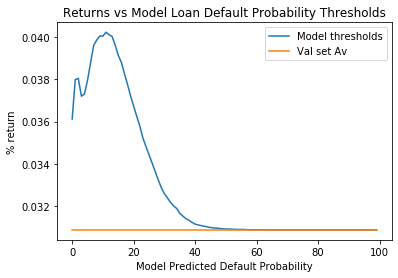

In [16]:
# plot returns at different thresholds vs total val_df returns
plt.plot(returns)
plt.plot([val_df.returns.mean()]*len(thresholds))
plt.xlabel('Model Predicted Default Probability')
plt.ylabel('% return')
plt.title('Returns vs Model Loan Default Probability Thresholds')
plt.legend(['Model thresholds', 'Val set Av'])

In [17]:
max(returns) - val_df.returns.mean()

0.009315742719565454

So far our model can generate a 0.9% greater return than average loan performance.

What happens if we predict return on investment for our loans directly instead of default probability?

In [18]:
y_train = train_df['returns']
y_val = val_df['returns']

In [19]:
# lgbm with default params
params = {'num_leaves': 32,
          'metric': 'rmse',}

# prepare data
train_data = lgb.Dataset(x_train,label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

# train
retuns_model = lgb.train(params,
                         train_data,
                         num_boost_round=1000,
                         valid_sets = [train_data, val_data],
                         verbose_eval=100,
                         early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.142708	valid_1's rmse: 0.15895
Early stopping, best iteration is:
[78]	training's rmse: 0.143728	valid_1's rmse: 0.158918


In [20]:
pred_returns = retuns_model.predict(x_val)

In [21]:
val_df['pred_returns'] = pred_returns

Next plot returns for different investment thresholds

In [22]:
returns = []
for t in np.arange(val_df['pred_returns'].min(),val_df['pred_returns'].max(), 0.01):
    av_return = val_df.loc[val_df['pred_returns']>=t, 'returns'].mean()
    # also store how many potential loans there are to invest
    total_loans = len(val_df.loc[val_df['pred_returns']>=t, 'total_pymnt'])
    returns.append((av_return, t, total_loans))

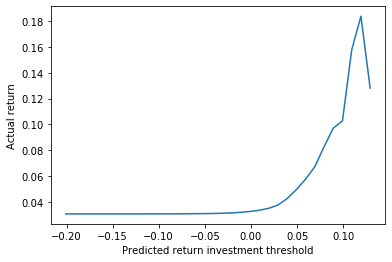

In [23]:
plt.figure()
plt.plot([x[1] for x in returns], [x[0] for x in returns])
plt.plot(val_df.returns.mean())
plt.xlabel('Predicted return investment threshold')
plt.ylabel('Actual return');

There is potential to earn a higher return by training a model directly on predicted annualized return. Because there are fewer loans available the pickier we become in selecting loans, it is important to set a base amount to invest. Then we can chose a predicted return threshold that balances total returns, and total loans available at that threshold.

It is also recommened to hold at least 100 loans to properly diversify your portfolio, so lets ensure 100+ loans available at a given threshold.

In [24]:
# this shows actual return followed by predicted returnes, and num loans available at that threshold
returns.sort(key=lambda x: x[1], reverse=True)
returns[:10]

[(0.12810447730083285, 0.12921895126172506, 1),
 (0.1836113213004344, 0.11921895126172505, 7),
 (0.15759734732158398, 0.10921895126172504, 17),
 (0.10282868056834818, 0.09921895126172503, 85),
 (0.09713772774144191, 0.08921895126172502, 291),
 (0.08273183311418196, 0.07921895126172501, 1095),
 (0.06739646911032433, 0.069218951261725, 4996),
 (0.05771921634655782, 0.059218951261724995, 18748),
 (0.04969216995291766, 0.049218951261724986, 46362),
 (0.04272855678693795, 0.03921895126172498, 93040)]

Row 5 looks like a great investment threshold. It had an annualized return over 9% with almost 300 loans available to invest in.

In [25]:
returns[4]

(0.09713772774144191, 0.08921895126172502, 291)

In [26]:
10000*(1+returns[4][0])**3

13206.369638401658

An initial 10,000 investment would grow to 13200 over 3 years!